In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# Modify path to find code directory:
import sys
sys.path.append('../code/')

import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import itertools


In [3]:
from structures import *
from utils import initialize_rewards, initialize_values, policy_iteration


In [4]:
agents = [
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
]

# Add some connections (only use inner circle):
agents[0].inner_circle.append(agents[1].id)
agents[1].inner_circle.append(agents[0].id)
agents[1].inner_circle.append(agents[2].id)
agents[2].inner_circle.append(agents[1].id)
agents[1].inner_circle.append(agents[3].id)
agents[3].inner_circle.append(agents[1].id)
agents[3].inner_circle.append(agents[4].id)
agents[4].inner_circle.append(agents[3].id)

# - REMINDER - Do we want to have connections automatically propagate both ways when specified?

# Build simulation environment:
env = Environment(agents, seed=182)
print(env)


<Environment with 0/5 informed agents>


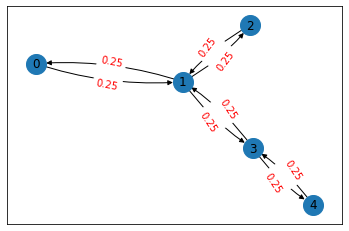

In [5]:
env.plot_network_graph()


In [7]:
env.update_transition_matrix(intervention_n=1)


# Initialize a policy and MDP problem setup
initial_policy = np.zeros(len(env.state_space), dtype=int)
rewards = initialize_rewards(env.state_space)
values = initialize_values(env.state_space)

optimal_policy = policy_iteration(env, initial_policy, values, rewards, gamma = 0.99, epsilon=1e-8)

20 iterations run - max delta = 0.0349327440464009
40 iterations run - max delta = 0.00031544667280858363
60 iterations run - max delta = 1.7495377369058929e-06
80 iterations run - max delta = 7.856618466917098e-09


In [8]:
optimal_policy

array([1, 1, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 3, 2, 2, 2, 3, 3,
       4, 1, 4, 2, 2, 2, 4, 3, 4, 0])

In [212]:
def initialize_values(state_space):
    """
    Value array for states (1D)
    """
    values = np.zeros(len(state_space))
    return values

def initialize_rewards(state_space):
    """
    Create a R(s,'s) matrix (reward can be thought of as independent of action)
    The reward is equal to the increase in the number of agents influenced
    """
    R = np.zeros((len(state_space), len(state_space)))
    for i, state1 in enumerate(state_space):
        for j, state2 in enumerate(state_space):
            reward = np.max((0, (np.sum(state2) - np.sum(state1))))
            R[i,j] = reward
    return R
    

In [254]:
def calculate_policy_value(env, policy, values, rewards, gamma = 0.85, epsilon=0.01):
    """

    """
    new_values = values.copy()
    delta = 1e9 # arbitrarily large number
    counter = 0

    while True:
        deltas = []
        for state_index, state in enumerate(env.state_space):
            
            # Extract the values relevant to the current state
            cur_value = new_values[state_index]
            cur_action_index = policy[state_index]
            
            transition_matrix = env.T[cur_action_index,state_index,:]
            reward_matrix = rewards[state_index,:].reshape(-1,)

            # Calculate the next value using Bellman update
            next_value = np.matmul(transition_matrix, (reward_matrix + gamma * new_values))
            
            # Update the value matrix 
            new_values[state_index] = next_value
            deltas.append(abs(next_value - cur_value))

        counter += 1
        if counter % 20 == 0:
            print(f"{counter} iterations run - max delta = {np.max(deltas)}")
        if np.max(deltas) < epsilon:
            break

    return new_values


In [255]:
def calculate_policy_improvement(env, policy, values, gamma=0.85):
    """

    """
    stable_policy=True
    new_policy = policy.copy()

    for state_index, state in enumerate(env.state_space):

        old_policy = policy.copy()

        # Calculate the value of taking a specific action followed by the
        # original policy
        action_values = []
        for action_index, action in enumerate(env.action_space):
            action_value = np.matmul(env.T[action_index, state_index, :], 
                                     (rewards[state_index,:] + gamma * values))
            action_values.append(action_value)
        
        best_action = np.argmax(action_values)

        # Update the policy
        new_policy[state_index] = best_action

        if new_policy[state_index] != old_policy[state_index]:
            stable_policy = False

    return new_policy, stable_policy


In [256]:
def policy_iteration(env, policy, values, rewards, gamma = 0.85, epsilon=0.01):
    """

    """
    stable = False
    new_policy = policy.copy()
    new_values = values.copy()

    while stable == False:
        new_values = calculate_policy_value(env, new_policy, new_values, rewards, gamma = gamma, epsilon=epsilon)
        new_policy, stable = calculate_policy_improvement(env, new_policy, new_values, gamma= gamma) 

    return new_policy       

In [257]:
# Implement policy iteration algorithm

# Initialize a policy and MDP problem setup
initial_policy = np.zeros(len(env.state_space), dtype=int)
rewards = initialize_rewards(env.state_space)
values = initialize_values(env.state_space)

optimal_policy = policy_iteration(env, initial_policy, values, rewards, gamma = 0.99, epsilon=1e-8)

20 iterations run - max delta = 0.0349327440464009
40 iterations run - max delta = 0.00031544667280858363
60 iterations run - max delta = 1.7495377369058929e-06
80 iterations run - max delta = 7.856618466917098e-09


In [258]:
optimal_policy


array([1, 1, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 3, 2, 2, 2, 3, 3,
       4, 1, 4, 2, 2, 2, 4, 3, 4, 0])

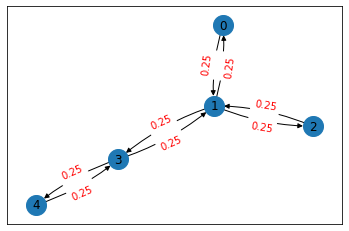

In [232]:
env.plot_network_graph()

In [218]:
env.state_space


[(0, 0, 0, 0, 0),
 (0, 0, 0, 0, 1),
 (0, 0, 0, 1, 0),
 (0, 0, 0, 1, 1),
 (0, 0, 1, 0, 0),
 (0, 0, 1, 0, 1),
 (0, 0, 1, 1, 0),
 (0, 0, 1, 1, 1),
 (0, 1, 0, 0, 0),
 (0, 1, 0, 0, 1),
 (0, 1, 0, 1, 0),
 (0, 1, 0, 1, 1),
 (0, 1, 1, 0, 0),
 (0, 1, 1, 0, 1),
 (0, 1, 1, 1, 0),
 (0, 1, 1, 1, 1),
 (1, 0, 0, 0, 0),
 (1, 0, 0, 0, 1),
 (1, 0, 0, 1, 0),
 (1, 0, 0, 1, 1),
 (1, 0, 1, 0, 0),
 (1, 0, 1, 0, 1),
 (1, 0, 1, 1, 0),
 (1, 0, 1, 1, 1),
 (1, 1, 0, 0, 0),
 (1, 1, 0, 0, 1),
 (1, 1, 0, 1, 0),
 (1, 1, 0, 1, 1),
 (1, 1, 1, 0, 0),
 (1, 1, 1, 0, 1),
 (1, 1, 1, 1, 0),
 (1, 1, 1, 1, 1)]

In [219]:
env.action_space


[(0,), (1,), (2,), (3,), (4,)]